# **ResNet20: Training, Filter-Level Pruning and Experiments on CIFAR-10**

В этом ноутбуке происходит работа с исходным кодом из [репозитория](https://github.com/MakhmoodSodikov/ResNet20-filter-pruning.git). 

Подробное описание архитектуры и работы с репозиторием, вместе с описанием модулей и мини-документацией, в [README](https://github.com/MakhmoodSodikov/ResNet20-filter-pruning/blob/main/README.md).

### **Часть 1. Обучение модели**

В самом начале, выполним технические моменты, касающиеся запуска обучения на удаленном девайсе, в моем случае в Google.Colab.

In [1]:
"""
! Run this cell, if you are working in Colab
"""

! git clone https://github.com/MakhmoodSodikov/ResNet20-filter-pruning.git
%cd ResNet20-filter-pruning

Cloning into 'ResNet20-filter-pruning'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 6), reused 22 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.
/content/ResNet20-filter-pruning


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! git pull

Already up to date.


Подключим необходимые модули.

In [22]:
from model.resnet20 import ResNet20
import torch
from train import train
from utils import random_inference
from dataloader.cifar10_loader i### **Часть 1. Обучение модели**mport val_loader

Обучим написанную модель из `resnet20.py`.

Подробное описание модели в файле `_torch_model_desc.txt`. Устройство модели и определение ResNet20 взяты из [оригинальной статьи](https://arxiv.org/abs/1512.03385).

Из гиперпараметров я оставил только количество эпох, остальные гиперпараметры подобраны валидацией эмпирически и записаны в `config.py`. 
При желании, можно их менять и протестировать качество работы.

Я использую планировщик MultiStepLR. По дефолту, редьюс шага обучения происходит на 40-й и 70-й эпохах.

По достижению required_precision модель сохраняется в директорию `models` с названием `best_model_%N%`, где вместо `%N%` - точность предсказания модели на топ-k.

Также, каждые 10 эпох сохраняются чекпоинты. :)

current lr 1.00000e-03
Precision @ k 89.920


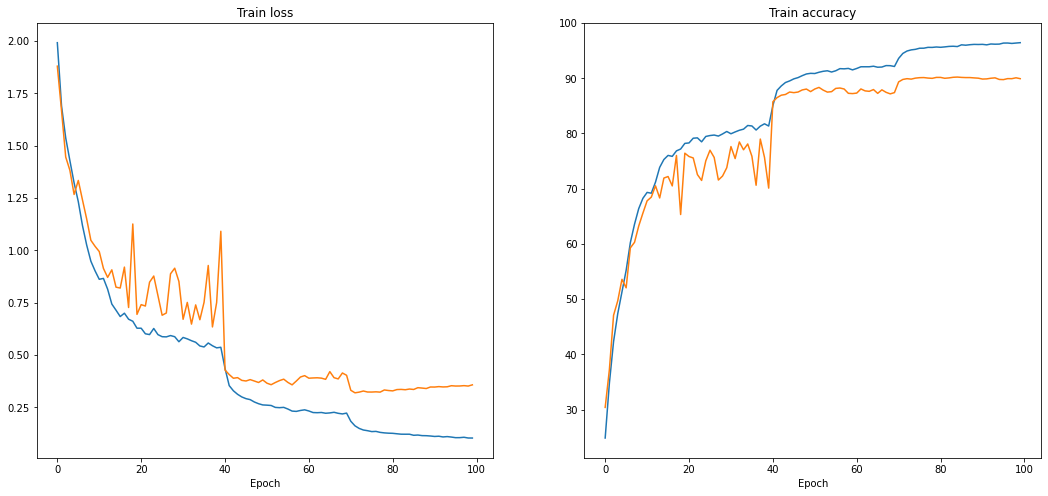

<Figure size 720x864 with 0 Axes>

In [13]:
model = ResNet20().cuda()
train(model, required_precision=90)

Видим стандартную кривую ошибки и точности для ResNet-модели, с характерными "волновыми" спадами ошибки на эпохах, где модель выходила на плато и происходили редьюсы шага обучения оптимизатора.

### **Часть 2. Инференс модели**

Загрузим лучшую модель. 

В моем случае, -- это модель с точностью **90.21%**. 

*(Веса модели есть в папке /models/).*

In [26]:
dump = torch.load('models/best_model_90.21.th')
print('Best model accuracy: ', dump['precision'])

Best model accuracy:  90.21


In [33]:
best_model = ResNet20().cuda()
best_model.load_state_dict(dump['state_dict'])

<All keys matched successfully>

Протестриуем, как модель предскажет лейблы для случайных фотографий из датасета.

*Функция `random_reference()` принимает на вход модель, на выходе генерирует батч из исходного датасета, кормит модели, считает точность, а для случайного семпла из батча еще и выводит предсказанные и правильные лейблы.*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


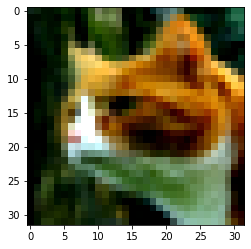

True label: cat
Predicted label: cat
Accuracy on batch: 90.625


In [46]:
random_inference(best_model)

Все ОК. 

Приступим к работе с прунингом.

### **Часть 3. Filter-Level Pruning**.

Сначала напишу пару слов про прунинг в целом и оставлю референсы. 

**TL;DR**

Вообще, прунинг для глубоких сверточных нейросетей для CV схож с методом дистилляции для трансформеров в NLP.


Эти обе техники применяются: а) для банального уменьшения объема модели (особенно это актуально, когда параметров миллионы, а запускать модель нужно на не очень мощном девайсе) б) для повышения робастности модели за счет удаления весов модели, обусловившихся на выбросы. То есть, как вариант регуляризации модели и/или его компрессии.

И в данном случае, эти подходы из мира глубоких сетей имеют мало общего со своим прародителем -- прунингом решающих деревьев (хотя предназначаются для одних и тех же целей). 

Вариантов прунинга, в частности, которые касаются сверточных нейросетей, тоже несколько. 

В моем случае, я сначала попробую "наивный" метод -- обычную кластеризацию с помощью KMeans-алгоритма. 

Далее, попробуем применить чуть более изощренный метод, лучше адаптированный под сверточные нейросети и сравним наши подходы. 

***Идея очень простая.***

1.   Берутся матрицы весов сверточных фильтров в каждой из сверточных слоев;
2.   Для каждого набора фильтров происходит кластеризация на K классов, а далее каждый слой заменяется своим центроидом.

*Гипотеза тоже простая - каждый фильтр в одном и том же слое, по сути, отличается на какое-то афинное преобразование (сдвиг, сжатие) в матричном пространстве размера фильтров. Каждый центроид, при таком предположении, будет являться базисной матрицей. Т.к. они все независимы по предположению кластеризации, то эта система будет линейно независимой.*



Как я понимаю, качество модели, в конце концов, должно упасть. 

Но можно попробовать дообучить несколько эпох после прунинга и это должно дать некоторое, может незначительное, но повышение качества.  

Также, можно дообучить как предлагается в задание -- после каждого шага обучения обновлять кластеры.

In [296]:
from pruning import *

В папке `pruning` содержатся все необходимые для прунинга утилиты. 

Попробуем проварьировать К - количество кластеров (по сути, единственно доступный нам гиперпараметр).



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


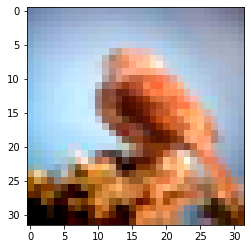

True label: bird
Predicted label: bird
Accuracy on batch: 50.0


In [344]:
random_inference(filter_pruning_20('models/best_model_90.1.th').cuda())

Как видим, сразу падает качество. 

Попробуем выправить качество поиском по сетке значений K.

Для этого, попробуем различное количество кластеров для начала и хвоста нашей нейросети.

Также, попробуем и наоборот.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


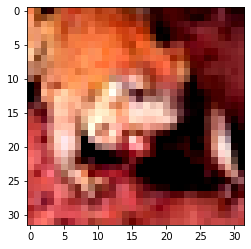

True label: frog
Predicted label: cat
Accuracy on batch: 46.875


In [357]:
runners = {'layer0': 5, 'layer1': 7, 'layer2': 20, 'layer3': 40}
random_inference(fix_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


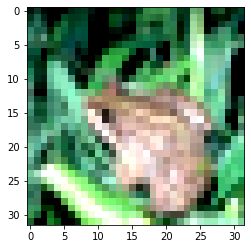

True label: frog
Predicted label: bird
Accuracy on batch: 57.8125


In [346]:
runners = {'layer0': 10, 'layer1': 10, 'layer2': 25, 'layer3': 50}
random_inference(fix_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


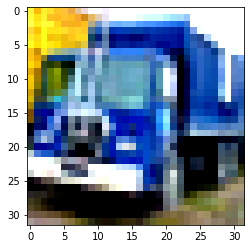

True label: truck
Predicted label: car
Accuracy on batch: 32.03125


In [354]:
runners = {'layer0': 16, 'layer1': 13, 'layer2': 10, 'layer3': 3}
random_inference(fix_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


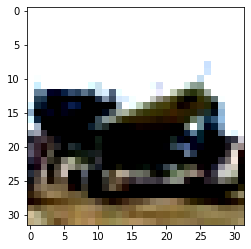

True label: plane
Predicted label: car
Accuracy on batch: 64.0625


In [358]:
runners = {'layer0': 13, 'layer1': 13, 'layer2': 25, 'layer3': 56}
random_inference(fix_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Как видим, предсказания модели стали более "рассеянными" - она "путает" грузовик с машиной, собаку с лошадью и птицу с лягушкой. 

Это объясняется как раз тем, что мы аппроксимировали некоторые фильтры довольно грубыми их приближениями, в следствие чего дисперсия ответов нейросети естественно увеличилась.

Попробуем теперь варьировать количество кластеров внутри **одного блока**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


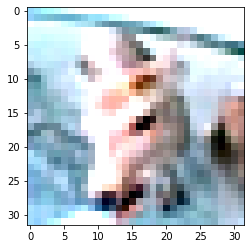

True label: deer
Predicted label: dog
Accuracy on batch: 59.375


In [359]:
runners = {'layer0': 10, 'layer1': list(range(16, 9, -1)), 'layer2': list(range(32, 25, -1)), 'layer3': list(range(64, 57, -1))}
random_inference(flex_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


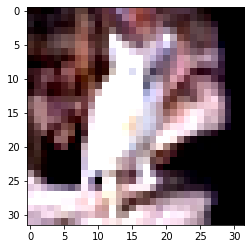

True label: cat
Predicted label: frog
Accuracy on batch: 64.84375


In [360]:
runners = {'layer0': 10, 'layer1': list(range(9, 16)), 'layer2': list(range(25, 32)), 'layer3': list(range(57, 64))}
random_inference(flex_num_clusters_test('models/best_model_90.1.th', runners).cuda())

Как видим, ошибки нейросети имеют тот же характер.

Сделаем небольшой "smoke"-тест нашего подхода -- тривиальная проверка правильности работы -- запустим кластеризацию, при K близких ко значению элементов в кластере.

Должны получить, конечно, качество, близкое к бенчмарку.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


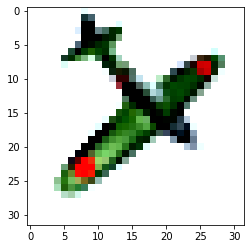

True label: plane
Predicted label: plane
Accuracy on batch: 80.46875


In [361]:
runners = {'layer0': 30, 'layer1': 30, 'layer2': 60, 'layer3': 120}
random_inference(fix_num_clusters_test('models/best_model_90.1.th', runners).cuda())

### **Часть 4. Визуализация результатов.**

Посмотрим также на зависимость качества предсказания от количества кластеров.

In [362]:
from utils import plot_acc_from_k

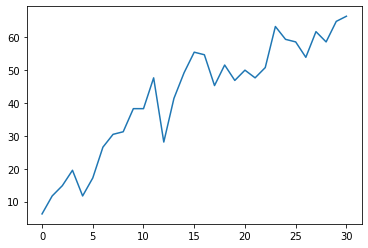

In [371]:
plot_acc_from_k('models/best_model_90.21.th')

Наша гипотеза подтвердилась - зависимость (при грубом приближении) окололинейная. 

Небольшие скачки и локальные колебания объясняются тем, что увеличение в каждом из слоев происходит неравномерно относительно количества элементов в каждом блоке. 

*TODO: можно проверить зависимость при изменении K в выборочных блоках, при этом оставлять без изменений остальные блоки полностью.*

### **Часть 5. Заключение, мысли, идеи.**


В заключение хочется сказать, что появилось несколько новых гипотез, которые можно проверить.

Например, можно проанализировать отдельно каждый из блоков и понять эмпирически приемлемые значения К для каждого из них и прокластеризовать каждый блок по отдельности, не затрагивая при этом другие блоки. 

Помимо этого, можно прибегнуть к результатам некоторых статей по теме Filter-Pruning'a сверточных нейросетей. 

Одна из [них](https://arxiv.org/abs/1905.00136) описывает метод жадного максимального сжатия (даже в 60 раз, как утверждается) ResNet'a. Суть сжатия основывается на нескольких эвристиках, таких как, например, учет "неиспользуемых путей" (unused path). Предлагается алгоритм для поиска и вообще удаления ненужных фильтров. 

Также, можно провести базовый корреляционный анализ сверток между собой. Можно его усложнить, применив что-то похожее на Attention Mechanism (или вообще Self-Attention), унаследовав эти подходы из NLP.

Что точно стало понятно -- улучшить качество выше бенчмарка очень сложно, если вообще возможно. Все-таки сжатия являются мерой, в первую очередь, уменьшения объема сети, чтобы быстрее получать ответы в инференс-режиме. Поэтому это все еще открытая задача, и до сих пор публикуются [статьи](https://arxiv.org/pdf/1911.08630.pdf) на эту тему.

